In [1]:
import easyocr
import numpy as np

In [4]:
X = np.load('c:/3rd_project/data/images/movie/X_total_color.npy')
y = np.load('c:/3rd_project/data/images/movie/y_total_color.npy')

In [5]:
import easyocr
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

from konlpy.tag import Kkma

class Ocr:
    def __init__(self, img):
        self.img = img

    def text_detect(self):
        # img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        reader = easyocr.Reader(['ko', 'en'], gpu = True)
        result = reader.readtext(self.img)

        # img = cv2.resize(img_cv2, (320, 448))
        image = Image.fromarray(self.img)
        font = ImageFont.truetype('C:/Users/tjoeun/AppData/Local/Microsoft/Windows/Fonts/NanumGothicBold.ttf', 10)
        draw = ImageDraw.Draw(image)
        np.random.seed(42)
        COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")
        for i in result :
            x = i[0][0][0] 
            y = i[0][0][1] 
            w = i[0][1][0] - i[0][0][0] 
            h = i[0][2][1] - i[0][1][1]

            # color_idx = random.randint(0,255) 
            # color = [int(c) for c in COLORS[color_idx]]
            color_idx = random.randint(0, len(COLORS) - 1)
            color = [int(c) for c in COLORS[color_idx]]

            draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
            draw.text((int((x + x + w) / 2) , y-2),str(i[1]), font=font, fill=tuple(color),)

        # plt.figure(figsize=(10,20))
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        # print(result)

    def image_to_text(self):
        # 추출된 텍스트 영역을 이용하여 각각의 텍스트를 잘라내고 EasyOCR을 다시 적용
        reader = easyocr.Reader(['ko', 'en'], gpu=True)
        result = reader.readtext(self.img)
        
        origin_results = []
        roi_results = []
        roi_gray_results =[]
        roi_2_results =[]
        roi_equal_results =[]
        roi_dil_results =[]
        roi_ero_results =[]
        roi_canny_results =[]

        for (box, text, confidence) in result:
            try:
                origin_results.append(text)
            except:
                pass

            # 각 텍스트 박스의 좌표 추출
            (startX, startY) = box[0]
            (endX, endY) = box[2]
            
            # 좌표를 정수로 변환
            startX, startY, endX, endY = int(startX), int(startY), int(endX), int(endY)

            # print(startX, startY, endX, endY)
            # 좌표가 음수이거나 이미지 범위를 벗어나는 경우 무시
            if startX < 0 or startY < 0 or endX >= self.img.shape[1] or endY >= self.img.shape[0]:
                continue

            # 텍스트 영역 추출
            roi = self.img[startY:endY, startX:endX]

            ############################################# 이미지 전처리 ###################################################

            # 이미지를 그레이스케일로 변환
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

            # 적응형 이진화 수행
            roi_adaptive_thresh = cv2.adaptiveThreshold(roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)

            # 히스토그램 평탄화 수행
            roi_equalized = cv2.equalizeHist(roi_gray)

            # 팽창
            kernel = np.ones((3, 3), np.uint8)
            roi_dilation = cv2.dilate(roi, kernel, iterations=1)

            # 침식
            kernel = np.ones((3, 3), np.uint8)
            roi_erosion = cv2.erode(roi, kernel, iterations=1)

            # 캐니
            roi_canny = cv2.Canny(roi, 475, 500, apertureSize=3, L2gradient=True)

            ############################################# 텍스트 인식 ###################################################

            # 잘라낸 텍스트 영역에 EasyOCR을 적용
            roi_result = reader.readtext(roi)
            roi_gray_result = reader.readtext(roi_gray)
            roi_2_result = reader.readtext(roi_adaptive_thresh)
            roi_equal_result = reader.readtext(roi_equalized)
            roi_dil_result = reader.readtext(roi_dilation)
            roi_ero_result = reader.readtext(roi_erosion)
            roi_canny_result = reader.readtext(roi_canny)

            ############################################# 결과 출력 ###################################################

            print("부분")
            plt.imshow(roi)
            try:
                print(f'Text: {roi_result[0][1]}, Confidence: {roi_result[0][2]}')
                roi_results.append(roi_result[0][1])
            except:
                print("Not Detect")
                roi_results.append('None')
            plt.axis('off')
            plt.show()

            print("그레이 스케일")
            plt.imshow(roi_gray, cmap="gray")
            try:
                print(f'Text: {roi_gray_result[0][1]}, Confidence: {roi_gray_result[0][2]}')
                roi_gray_results.append(roi_gray_result[0][1])
            except:
                print("Not Detect")
                roi_gray_results.append('None')
            plt.axis('off')
            plt.show()

            print("적응형 이진화")
            plt.imshow(roi_adaptive_thresh, cmap="gray")
            try:
                print(f'Text: {roi_2_result[0][1]}, Confidence: {roi_2_result[0][2]}')
                roi_2_results.append(roi_2_result[0][1])
            except:
                print("Not Detect")
                roi_2_results.append('None')
            plt.axis('off')
            plt.show()

            print("히스토그램 평탄화")
            plt.imshow(roi_equalized)
            try:
                print(f'Text: {roi_equal_result[0][1]}, Confidence: {roi_equal_result[0][2]}')
                roi_equal_results.append(roi_equal_result[0][1])
            except:
                print("Not Detect")
                roi_equal_results.append('None')
            plt.axis('off')
            plt.show()

            print("팽창")
            plt.imshow(roi_dilation)
            try:
                print(f'Text: {roi_dil_result[0][1]}, Confidence: {roi_dil_result[0][2]}')
                roi_dil_results.append(roi_dil_result[0][1])
            except:
                print("Not Detect")
                roi_dil_results.append('None')
            plt.axis('off')
            plt.show()

            print("침식")
            plt.imshow(roi_erosion)
            try:
                print(f'Text: {roi_ero_result[0][1]}, Confidence: {roi_ero_result[0][2]}')
                roi_ero_results.append(roi_ero_result[0][1])
            except:
                print("Not Detect")
                roi_ero_results.append('None')
            plt.axis('off')
            plt.show()

            print("캐니")
            plt.imshow(roi_canny)
            try:
                print(f'Text: {roi_canny_result[0][1]}, Confidence: {roi_canny_result[0][2]}')
                roi_canny_results.append(roi_canny_result[0][1])
            except:
                print("Not Detect")
                roi_canny_results.append('None')
            plt.axis('off')
            plt.show()
        return origin_results, roi_results, roi_gray_results, roi_2_results, roi_equal_results, roi_dil_results, roi_ero_results, roi_canny_results


class Get_Nouns:
    def __init__(self, i2t_text):
        self.text = i2t_text

    def get_nouns(self):
        kkma = Kkma()
        nouns = kkma.nouns(str(self.text))
        return nouns

    def get_nouns_list(self):
        i2t_nouns = self.get_nouns()

        noun_list = []

        # 추출된 명사 출력
        for i2t_noun in i2t_nouns:
            if len(i2t_noun) > 1:
                noun_list.append(i2t_noun)

        noun_list = list(set(noun_list))
        return noun_list

### 장르별 단어 txt파일 불러오기

In [6]:
def read_words_from_file(file_path):
    words = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # 줄바꿈 문자를 제거하고 단어를 리스트에 추가
            word = line.strip()
            words.append(word)
    return words

# 파일로부터 단어 리스트 불러오기
act_nouns = read_words_from_file('c:/3rd_project/data/act_nouns.txt')
ani_nouns = read_words_from_file('c:/3rd_project/data/ani_nouns.txt')
com_nouns = read_words_from_file('c:/3rd_project/data/com_nouns.txt')
dra_nouns = read_words_from_file('c:/3rd_project/data/dra_nouns.txt')
hor_nouns = read_words_from_file('c:/3rd_project/data/hor_nouns.txt')
etc_nouns = read_words_from_file('c:/3rd_project/data/etc_nouns.txt')

# 장르별 단어 빈도수

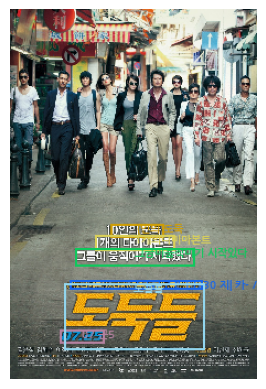

부분
Text: {인의 도둑, Confidence: 0.2215568122969222


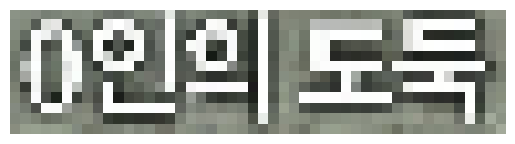

그레이 스케일
Text: {인의 도둑, Confidence: 0.2215568122969222


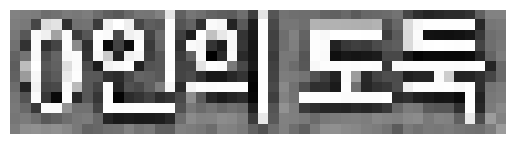

적응형 이진화
Text: @인의 도둑, Confidence: 0.049110079333726055


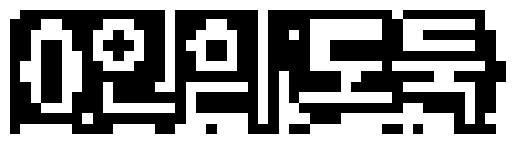

히스토그램 평탄화
Text: {인의 도둑, Confidence: 0.2027141369282423


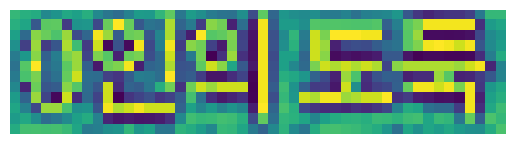

팽창
Not Detect


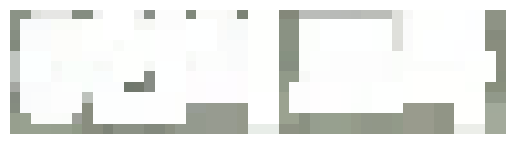

침식
Not Detect


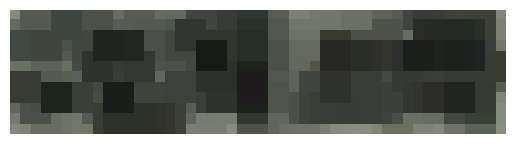

캐니
Not Detect


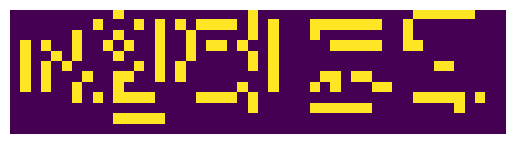

부분
Text: 1캐의다미마본트, Confidence: 0.2330136868556186


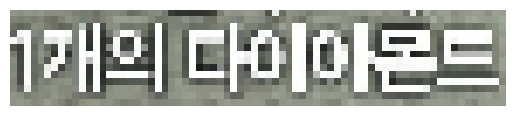

그레이 스케일
Text: 1캐의다미마본트, Confidence: 0.2330136868556186


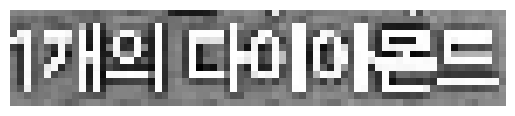

적응형 이진화
Text: 1개하-미하놔쪽, Confidence: 0.011818646669264696


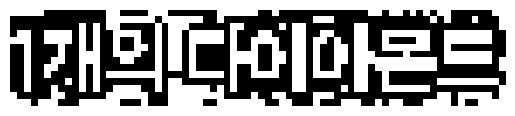

히스토그램 평탄화
Text: 1캐의다미미온트, Confidence: 0.32575569764934814


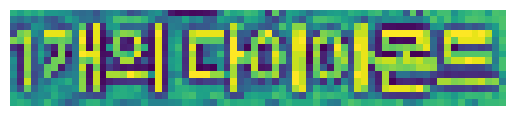

팽창
Not Detect


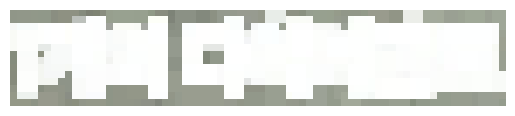

침식
Not Detect


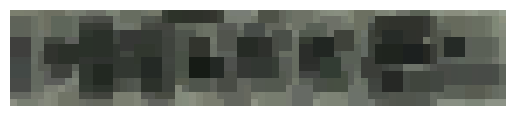

캐니
Text: i거 _기 제 트 =, Confidence: 0.01953501134852984


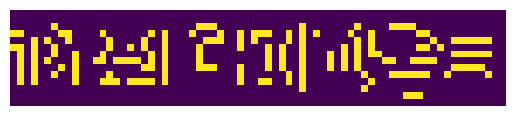

부분
Text: 그q미움직미기 시작맺다, Confidence: 0.178966219112336


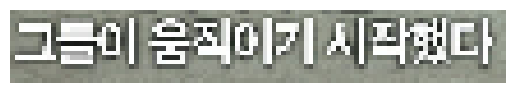

그레이 스케일
Text: 그금미움직미기 시작있다, Confidence: 0.22492764278693722


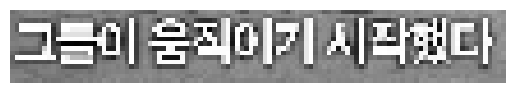

적응형 이진화
Text: 기문최픽기 제붕렉다=, Confidence: 0.002859601612179088


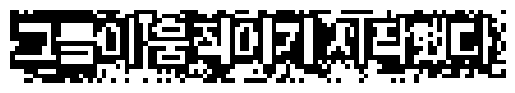

히스토그램 평탄화
Text: 그금미움직미키 지락럽다, Confidence: 0.07929426825553779


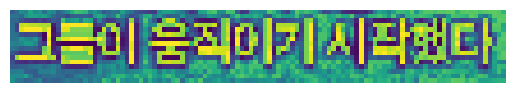

팽창
Not Detect


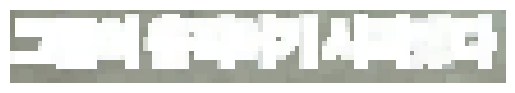

침식
Not Detect


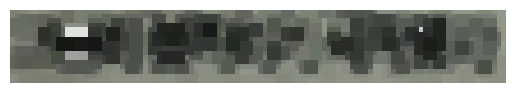

캐니
Text: 그근- ; ;기해기 비내[", Confidence: 0.02321921463433448


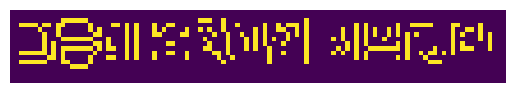

부분
Not Detect


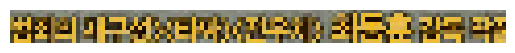

그레이 스케일
Not Detect


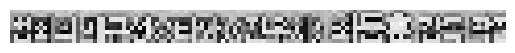

적응형 이진화
Not Detect


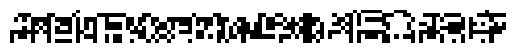

히스토그램 평탄화
Not Detect


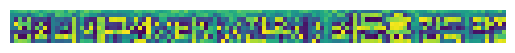

팽창
Not Detect


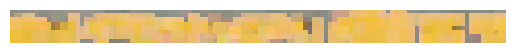

침식
Not Detect


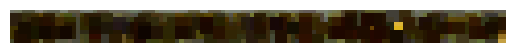

캐니
Not Detect


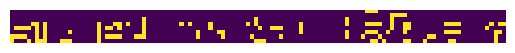

부분
Text: 07근5, Confidence: 0.5943267600778394


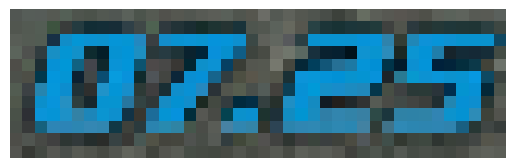

그레이 스케일
Text: 07근5, Confidence: 0.5943267600778394


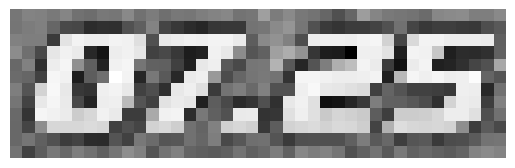

적응형 이진화
Not Detect


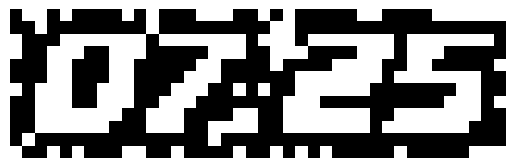

히스토그램 평탄화
Text: D7 _도, Confidence: 0.11027457427144487


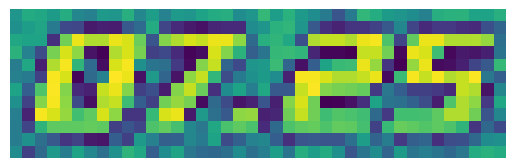

팽창
Not Detect


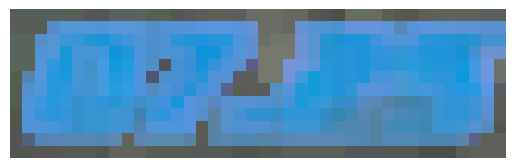

침식
Not Detect


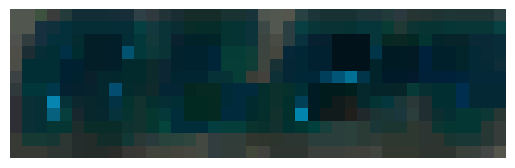

캐니
Text: D: LPr, Confidence: 0.00861336956493458


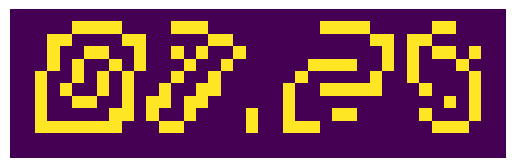

부분
Text: 도, Confidence: 0.9610477081033686


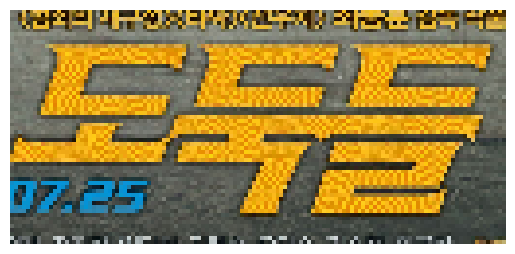

그레이 스케일
Not Detect


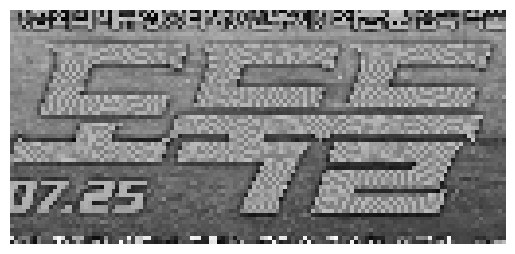

적응형 이진화
Not Detect


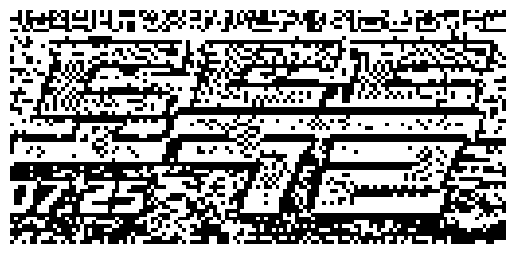

히스토그램 평탄화
Text: U7.E5, Confidence: 0.2638214289397574


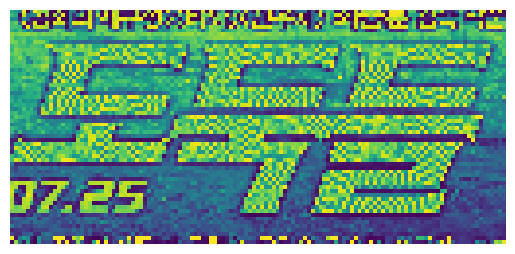

팽창
Text: P구, Confidence: 0.016610572793855777


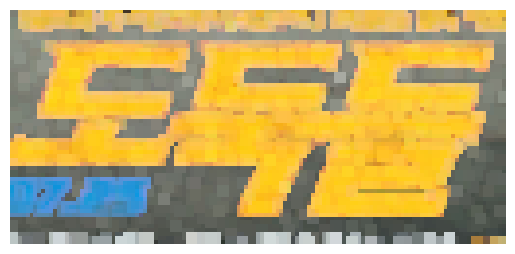

침식
Text: 도둑들, Confidence: 0.9719181435658486


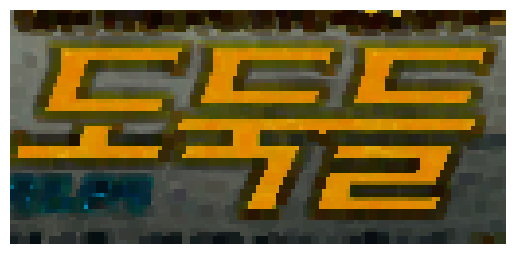

캐니
Text: 07,35, Confidence: 0.23385483239882388


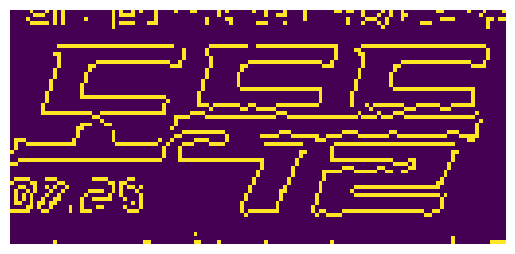

31
액션 단어 : 07
액션 단어 : 미미온트
액션 단어 : 하놔
액션 단어 : 7구3
액션 단어 : 35
액션 단어 : 금미움직
액션 단어 : 시작
액션 단어 : 개하
액션 단어 : 미하놔쪽
액션 단어 : 미키
액션 단어 : 캐의
액션 단어 : 1개하
액션 단어 : 1캐의
액션 단어 : 07근5
액션 단어 : 기해기
액션 단어 : 도둑
액션 단어 : 지락럽
액션 단어 : 근5
액션 단어 : 3730
액션 단어 : 인의
액션 단어 : 해기
액션 단어 : 지락
액션 단어 : 비내
액션 단어 : 미기
액션 단어 : 미움
액션 단어 : 미움직미기
액션 단어 : 본트
액션 단어 : 미마본트
액션 단어 : 기문최
액션 단어 : 온트
액션 단어 : 기문
액션 장르의 빈도수: 31
애니메이션 장르의 빈도수: 0
코미디 장르의 빈도수: 0
드라마 장르의 빈도수: 0
공포(호러) 장르의 빈도수: 0
기타 장르의 빈도수: 0


In [8]:
from collections import Counter

num = 555
img = X[num]
genre = y[num]

img = img

# 이미지 텍스트 추출
ocr = Ocr(img)
ocr.text_detect()
i2t_text = ocr.image_to_text()
# print(y[num])
gn = Get_Nouns(i2t_text)
nouns = gn.get_nouns_list()

act_freq = 0
ani_freq = 0
com_freq = 0
dra_freq = 0
hor_freq = 0
etc_freq = 0

print(len(nouns))

# 입력한 단어들의 빈도수 확인
for word in nouns:
    if word in act_nouns:
        print(f"액션 단어 : {word}")
        act_freq += 1
    elif word in ani_nouns:
        print(f"애니 단어 : {word}")
        ani_freq += 1
    elif word in com_nouns:
        print(f"코미디 단어 : {word}")
        com_freq += 1
    elif word in dra_nouns:
        print(f"드라마 단어 : {word}")
        dra_freq += 1
    elif word in hor_nouns:
        print(f"공포 단어 : {word}")
        hor_freq += 1
    else:
        print(f"기타 단어 : {word}")
        etc_freq += 1

# print(f"장르 : {genre}")
print(f"액션 장르의 빈도수: {act_freq}")
print(f"애니메이션 장르의 빈도수: {ani_freq}")
print(f"코미디 장르의 빈도수: {com_freq}")
print(f"드라마 장르의 빈도수: {dra_freq}")
print(f"공포(호러) 장르의 빈도수: {hor_freq}")
print(f"기타 장르의 빈도수: {etc_freq}")